# Определение наличия в тексте нецензурных слов с помощью глубокого обучения (нейронная сеть)

## Импорты

In [1]:
!pip3 install gensim==3.8.1

     |████████████████████████████████| 24.2MB 135kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import re
import torch
import nltk
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
from collections import OrderedDict
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm as tqdm_notebook
# from nltk.tokenize import WordPunctTokenizer

# nltk.download("punkt")

punct = punctuation+'«»—…“”*№–'

In [3]:
data_path = "/content/drive/MyDrive/thesis_datasets/obscene_data.csv"

test_data_path = '/content/drive/MyDrive/thesis_datasets/obscene_dataset_test.csv'
train_data_path = '/content/drive/MyDrive/thesis_datasets/obscene_dataset_train.csv'
valid_data_path = '/content/drive/MyDrive/thesis_datasets/obscene_dataset_valid.csv'

vector_model_path = "/content/drive/MyDrive/thesis_datasets/araneum_none_fasttextcbow_300_5_2018.model"

obscene_model_best_state_path = "/content/drive/MyDrive/thesis_datasets/obscene_model_best.pth"
obscene_opt_best_state_path = "/content/drive/MyDrive/thesis_datasets/obscene_opt_best.pth"
obscene_model_last_state_path = "/content/drive/MyDrive/thesis_datasets/obscene_model_last.pth"
obscene_opt_last_state_path = "/content/drive/MyDrive/thesis_datasets/obscene_opt_last.pth"

obscene_vocab_path = '/content/drive/MyDrive/thesis_datasets/obscene_vocab.json'

## Работа с несбалансированными данными

In [4]:
data = pd.read_csv(data_path)
data.dropna(inplace=True)

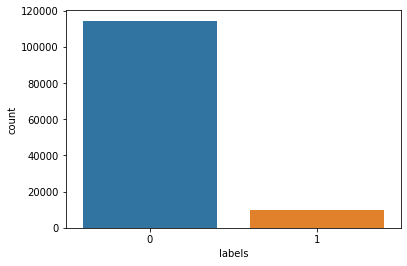

In [5]:
# sns.countplot(x='labels', data=data)

In [6]:
# data.head()

,Unnamed: 0,words,labels
0,55395,has,0
1,1559,выпиздошить,1
2,15179,обстаятельство,0
3,32323,dvach,0
4,45738,суккубик,0


In [10]:
# obscene = data[data.labels == 1]
# not_obscene = data[data.labels == 0]

In [11]:
# len(obscene)

9799

In [12]:
# len(not_obscene)

114372

### Подготовка данных

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(data.words, data.labels, test_size=0.05, random_state=42)

In [16]:
# len(X_train), len(X_test), len(y_train), len(y_test)

(117962, 6209, 117962, 6209)

In [19]:
# test_data = pd.DataFrame()
# test_data["words"] = X_test
# test_data["labels"] = y_test
# test_data.to_csv(test_data_path, index=False)

In [22]:
# train_words, valid_words, train_targets, valid_targets = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [23]:
# len(train_words), len(valid_words)

(106165, 11797)

In [24]:
# train_data = pd.DataFrame()
# train_data["words"] = train_words
# train_data["labels"] = train_targets
# train_data.to_csv(train_data_path, index=False)

# valid_data = pd.DataFrame()
# valid_data["words"] = valid_words
# valid_data["labels"] = valid_targets
# valid_data.to_csv(valid_data_path, index=False)

In [97]:
train_data = pd.read_csv(train_data_path)
valid_data = pd.read_csv(valid_data_path)

train_words = train_data["words"]
train_targets = train_data["labels"]
valid_words = valid_data["words"] 
valid_targets = valid_data["labels"]

### Эмбеддинги

In [6]:
fasttext = KeyedVectors.load(vector_model_path)

In [7]:
def get_vocab_embeddings(words, vector_model=fasttext):
    vocab = {'<UNK>': 0}
    embeddings = [np.zeros(300)]
    
    for word in tqdm_notebook(words):
        if word not in vocab:
            vocab[word] = len(vocab)
            embeddings.append(vector_model[word])
    return vocab, embeddings

In [8]:
%%time
vocab, embeddings = get_vocab_embeddings(data.words)


CPU times: user 10.5 s, sys: 1.52 s, total: 12 s
Wall time: 10.7 s


In [9]:
embeddings = torch.tensor(embeddings).float()

In [10]:
json_dump = json.dumps(vocab)
f = open(obscene_vocab_path, "w")
f.write(json_dump)
f.close()  

### Обработчик данных

In [11]:
class BaddWordClassifierDataset(Dataset):
    
    def __init__(self, words, targets, vocab, unknown_index=0):
        super().__init__()
        
        self.words = words
        self.targets = targets
        self.vocab = vocab
        self.unknown_index = unknown_index
        
    def __len__(self):

        return len(self.words)

    def get_word_index(self, word):

        return self.vocab[word] if word in self.vocab else self.unknown_index
    
    def __getitem__(self, index):
       
        word = self.words[index]    
        index_of_word = self.get_word_index(word)
        converted_word = torch.tensor(index_of_word)

        target = self.targets[index]

        return converted_word, target

In [98]:
train_dataset = BaddWordClassifierDataset(train_words, train_targets, vocab)
valid_dataset = BaddWordClassifierDataset(valid_words, valid_targets, vocab)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [13]:
for x, y in train_loader:
    break

In [14]:
x[0]

tensor(87762)

In [15]:
y[0]

tensor(0)

### Модель

In [ ]:
device = torch.device('cpu')

In [16]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [27]:
class BaddObsceneNN(torch.nn.Module):
    
    def __init__(self, 
                 embeddings, 
                 num_classes, 
                 linear_size_1, 
                 linear_size_2):
        
        super().__init__()

        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze=False)

        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        
        self.linear1 = nn.Linear(in_features=embeddings.shape[-1], 
                                 out_features=linear_size_1,
                                 bias=False)
        self.linear2 = nn.Linear(in_features=linear_size_1, 
                                 out_features=linear_size_2,
                                 bias=False)
        self.relu = nn.ReLU()
        self.output_layer = torch.nn.Linear(in_features=linear_size_2,
                                            out_features=num_classes,
                                            bias=False)

        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        x = self.batch_norm(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        
        return x

In [99]:
num_classes = 1
linear_size_1 = 254
linear_size_2 = 128

In [100]:
obscene_model = BaddObsceneNN(embeddings, 
                 num_classes, 
                 linear_size_1, 
                 linear_size_2)
obscene_model.to(device)

BaddObsceneNN(
  (embedding_layer): Embedding(124164, 300)
  (batch_norm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=300, out_features=254, bias=False)
  (linear2): Linear(in_features=254, out_features=128, bias=False)
  (relu): ReLU()
  (output_layer): Linear(in_features=128, out_features=1, bias=False)
)

### Обучение и валидация

In [20]:
def binarize(pred):
    pred = pred.cpu().detach().numpy()
    result = []
    for r in pred:
        if r <= 0.5:
            result.append(0.)
        else:
            result.append(1.)
    return result

In [21]:
def train_model(model, train_loader, optimizer, criterion, n_epoch, f_score_average, clip=3.0):

    train_losses = []
    f_scores_train = []

    model.train()
    
    train_progress_bar = tqdm_notebook(total=len(train_loader.dataset), desc=f'Epoch: {n_epoch + 1}, train', position=0, leave=True)
    

    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
            
        pred = model(x.detach())

        f_scores_train.append(f1_score(y.cpu().numpy(), binarize(pred), average=f_score_average))
        
        loss = criterion(pred.cpu().squeeze(), y.cpu().float())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())

        train_progress_bar.set_postfix(train_loss = np.mean(train_losses[-500:]))
        train_progress_bar.update(x.shape[0])

    train_progress_bar.close()

    return train_losses, f_scores_train

In [22]:
def validate_model(model, valid_loader, optimizer, criterion, n_epoch, f_score_average):

    valid_losses = []
    f_scores_valid = []

    model.eval()

    valid_progress_bar = tqdm_notebook(total=len(valid_loader.dataset), desc=f'Epoch: {n_epoch + 1}, validation', position=0, leave=True)

    for x, y in valid_loader:

        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():  
            pred = model(x.detach())

        f_scores_valid.append(f1_score(y.cpu().numpy(), binarize(pred), average=f_score_average))
        loss = criterion(pred.cpu().squeeze(), y.cpu().float())

        valid_losses.append(loss.item())

        valid_progress_bar.set_postfix(valid_loss = np.mean(valid_losses[-500:]))
        valid_progress_bar.update(x.shape[0])
    
    valid_progress_bar.close()

    return valid_losses, f_scores_valid

In [23]:
def save_model(model, optimizer, path_to_model_state, path_to_optimizer_state):
    torch.save(model.state_dict(), path_to_model_state)
    torch.save(optimizer.state_dict(), path_to_optimizer_state)

In [24]:
def train_and_validate(model,
                       n_epochs,
                       train_loader,
                       valid_loader,
                       model_params,
                       embedding_params,
                       f_score_average,
                       criterion,
                       optimizer,
                       scheduler,
                       best_model_state_path,
                       best_opt_state_path,
                       last_model_state_path,
                       last_opt_state_path):

    val_losses = []
    tr_losses = []
    mean_f_scores_train = []
    mean_f_scores_valid = []
    best_val_loss = 10.0

    for n_epoch in range(n_epochs):

        epoch_train_losses, f_scores_train = train_model(model, train_loader, optimizer, criterion, n_epoch, f_score_average)
        epoch_valid_losses, f_scores_valid = validate_model(model, valid_loader, optimizer, criterion, n_epoch, f_score_average)

        mean_epoch_val_loss = np.mean(epoch_valid_losses)
        mean_f_scores_train.append(np.mean(f_scores_train))
        mean_f_scores_valid.append(np.mean(f_scores_valid))
        val_losses.append(mean_epoch_val_loss)
        tr_losses.append(np.mean(epoch_train_losses))

        scheduler.step()

        if mean_epoch_val_loss < best_val_loss:
            best_val_loss = mean_epoch_val_loss
            print(f"F-score on validation: {np.mean(f_scores_valid)}")
            save_model(model, optimizer, best_model_state_path, best_opt_state_path)
        else:
            print(f'Early stopping on epoch {n_epoch+1}')
            print(f"F-score on validation: {np.mean(f_scores_valid)}")
            save_model(model, optimizer, last_model_state_path, last_opt_state_path)
            break

    return val_losses, tr_losses, mean_f_scores_train, mean_f_scores_valid

In [101]:
n_epochs = 30
model_params =  [x[1] for x in list(filter(lambda x: x[0] != 'embedding_layer.weight', obscene_model.named_parameters()))]
embedding_params = obscene_model.embedding_layer.parameters()
f_score_average = "micro"
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(params=[{'params': embedding_params, 'lr': 0.0001}, {'params': model_params, 'lr': 0.00001}])
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [102]:
%%time
valid_losses, train_losses, mean_f_scores_train, mean_f_scores_valid = train_and_validate(obscene_model,
                       n_epochs,
                       train_loader,
                       valid_loader,
                       model_params,
                       embedding_params,
                       f_score_average,
                       criterion,
                       optimizer,
                       scheduler,
                       obscene_model_best_state_path,
                       obscene_opt_best_state_path,
                       obscene_model_last_state_path,
                       obscene_opt_last_state_path)


F-score on validation: 0.9203549027137736



F-score on validation: 0.9196668586789555



F-score on validation: 0.9296034946236559



Early stopping on epoch 4
F-score on validation: 0.9326956925243215
CPU times: user 1min 10s, sys: 26.3 s, total: 1min 36s
Wall time: 1min 43s


### Графики

In [31]:
def show_f_scores_graph(f_scores, training=True, epoch=True):
    plt.figure(figsize=(7, 7))
    plt.plot(f_scores)
    plt.grid()
    if training:
      plt.title('F-scores on train')
    else:
      plt.title('F-scores on validation')
    if epoch:
      plt.xlabel('Epochs')
    else:
      plt.xlabel('Iterations')
    plt.ylabel('f-score')

In [32]:
def show_losses_graph(losses, training=True, epoch=True):
    plt.figure(figsize=(7, 7))
    plt.plot(losses)
    plt.grid()
    if training:
      plt.title('Training process')
    else:
      plt.title('Validation process')
    if epoch:
      plt.xlabel('Epochs')
    else:
      plt.xlabel('Iterations')
    plt.ylabel('Loss function')

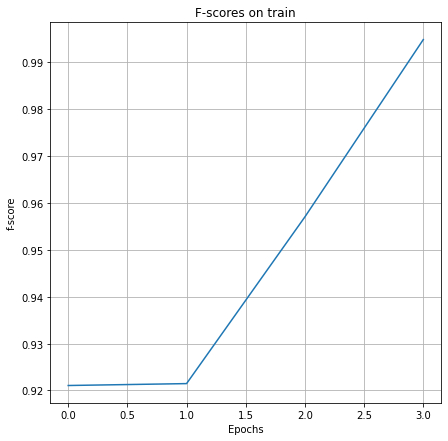

In [103]:
show_f_scores_graph(mean_f_scores_train, training=True)

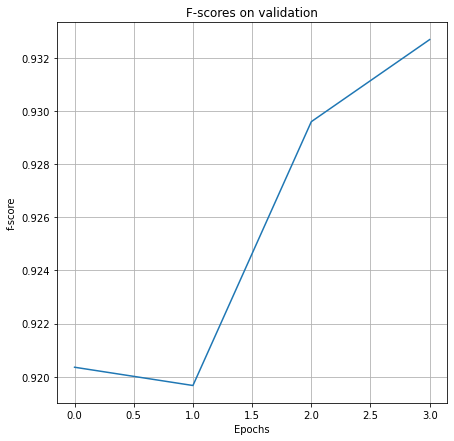

In [104]:
show_f_scores_graph(mean_f_scores_valid, training=False)

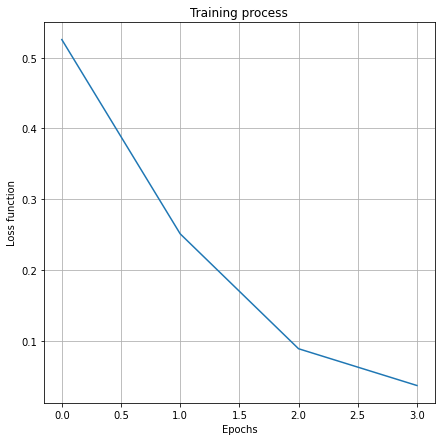

In [105]:
show_losses_graph(train_losses, training=True)

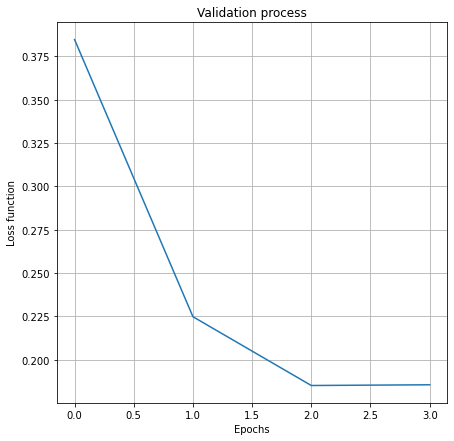

In [106]:
show_losses_graph(valid_losses, training=False)

### Оценка модели

In [ ]:
f = open(obscene_vocab_path, "r")
file = f.read()
f.close()  

vocab = json.loads(file)

In [107]:
test_data = pd.read_csv(test_data_path)

In [108]:
def load_model(path_to_model_state, path_to_optimizer_state):
    model_state = torch.load(path_to_model_state)
    optimizer_state = torch.load(path_to_optimizer_state)
    return model_state, optimizer_state

In [109]:
model, _ = load_model(obscene_model_best_state_path, obscene_opt_best_state_path)

In [110]:
obscene_model.load_state_dict(model)

<All keys matched successfully>

In [111]:
def predict_word(word, model, vocab=vocab):
    index = vocab[word] if word in vocab else 0
    tensor_index = torch.tensor(index)
    tensor_index = torch.unsqueeze(tensor_index,0)
    
    with torch.no_grad():
      pred = model.forward(tensor_index.to(device))
      pred = binarize(pred)
      return pred[0]

In [112]:
def make_preds(model, words):
    model.eval()
    y_preds = []
    for word in words:
        y_preds.append(predict_word(word, model))
    return y_preds

In [113]:
%%time
y_preds = make_preds(obscene_model, test_data.words)
y_trues = test_data.labels

CPU times: user 2.55 s, sys: 33.9 ms, total: 2.59 s
Wall time: 2.59 s


In [114]:
def evaluate_on_texts(y_trues, y_preds, f_score_average = "micro"):
    
    print(f"F1 score: {f1_score(y_trues, y_preds, average=f_score_average)}")
    print(f"Accuracy: {accuracy_score(y_trues, y_preds)}")
    print(classification_report(y_trues, y_preds))

In [115]:
evaluate_on_texts(y_trues, y_preds)

F1 score: 0.9330004831695925
Accuracy: 0.9330004831695925
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5735
           1       0.85      0.15      0.25       474

    accuracy                           0.93      6209
   macro avg       0.89      0.57      0.61      6209
weighted avg       0.93      0.93      0.91      6209



In [123]:
def probability_obscene(word, model, vocab=vocab):
    index = vocab[word] if word in vocab else 0
    tensor_index = torch.tensor(index)
    tensor_index = torch.unsqueeze(tensor_index,0)
    
    with torch.no_grad():
      pred = model.forward(tensor_index.to(device))
      pred = torch.sigmoid(pred).cpu().numpy()[0][0]
      return pred

obscene_model.eval()
words = ["собака", "охуенная", "кошка", "охуевшая", "человек", "пиздатый", "самолету", "пиздец"]
for word in words:
    print(probability_obscene(word, obscene_model))

0.001014386
0.65463793
0.00029839537
0.077259004
0.00023282443
0.6793468
0.077259004
0.9197907


## Эксперимент с работой со сбалансированными классами

In [49]:
data = pd.concat([train_data, valid_data]).sample(frac=1)

In [52]:
data.dropna(inplace=True)

In [53]:
obscene = data[data.labels == 1]
not_obscene = data[data.labels == 0]

In [54]:
len(obscene), len(not_obscene)

(9325, 108637)

In [55]:
not_obscene = not_obscene.sample(10000, random_state=42)

In [56]:
corpus = pd.concat([obscene, not_obscene]).sample(frac=1)

In [68]:
corpus.head()

,words,labels
89732,бздех,1
95977,кадр,0
5642,питер?ич,0
33477,интмайя,0
32817,свэгий,0


In [73]:
train_words, valid_words, train_targets, valid_targets = train_test_split(corpus.words.values.tolist(), corpus.labels.values.tolist(), test_size=0.1, random_state=42)

In [74]:
len(train_words), len(valid_words)

(17392, 1933)

In [77]:
train_dataset = BaddWordClassifierDataset(train_words, train_targets, vocab)
valid_dataset = BaddWordClassifierDataset(valid_words, valid_targets, vocab)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [78]:
for x, y in valid_loader:
    break

In [79]:
x[0]

tensor(21576)

In [80]:
y[0]

tensor(0)

In [81]:
obscene_model = BaddObsceneNN(embeddings, 
                 num_classes, 
                 linear_size_1, 
                 linear_size_2)
obscene_model.to(device)

BaddObsceneNN(
  (embedding_layer): Embedding(124164, 300)
  (batch_norm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=300, out_features=254, bias=False)
  (linear2): Linear(in_features=254, out_features=128, bias=False)
  (relu): ReLU()
  (output_layer): Linear(in_features=128, out_features=1, bias=False)
)

In [82]:
n_epochs = 30
model_params =  [x[1] for x in list(filter(lambda x: x[0] != 'embedding_layer.weight', obscene_model.named_parameters()))]
embedding_params = obscene_model.embedding_layer.parameters()
f_score_average = "micro"
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(params=[{'params': embedding_params, 'lr': 0.0001}, {'params': model_params, 'lr': 0.00001}])
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [83]:
%%time
valid_losses, train_losses, mean_f_scores_train, mean_f_scores_valid = train_and_validate(obscene_model,
                       n_epochs,
                       train_loader,
                       valid_loader,
                       model_params,
                       embedding_params,
                       f_score_average,
                       criterion,
                       optimizer,
                       scheduler,
                       obscene_model_best_state_path,
                       obscene_opt_best_state_path,
                       obscene_model_last_state_path,
                       obscene_opt_last_state_path)


F-score on validation: 0.5165640024038461



F-score on validation: 0.5220102163461539



F-score on validation: 0.6011493389423077



F-score on validation: 0.5829702524038461



F-score on validation: 0.6023512620192308



F-score on validation: 0.6010366586538461



F-score on validation: 0.6068209134615384



Early stopping on epoch 8
F-score on validation: 0.5977689302884616
CPU times: user 24.9 s, sys: 11.5 s, total: 36.3 s
Wall time: 1min 3s


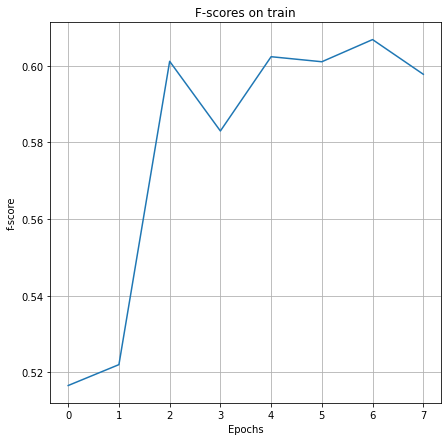

In [88]:
show_f_scores_graph(mean_f_scores_valid, training=True)

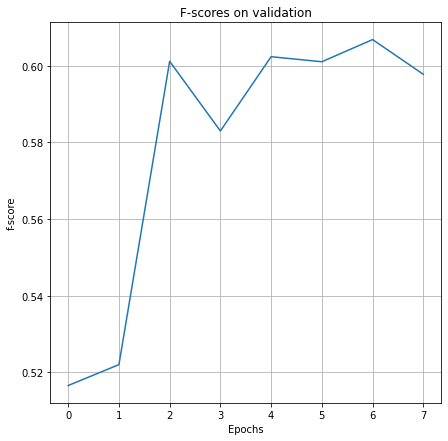

In [89]:
show_f_scores_graph(mean_f_scores_valid, training=False)

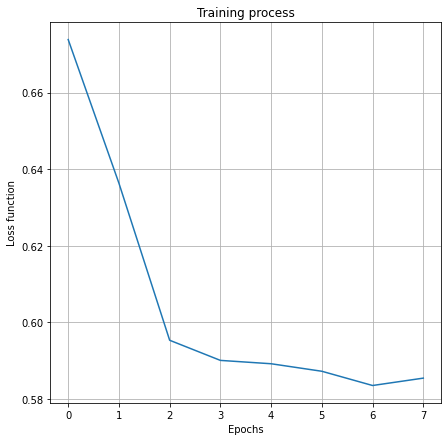

In [86]:
show_losses_graph(valid_losses, training=True)

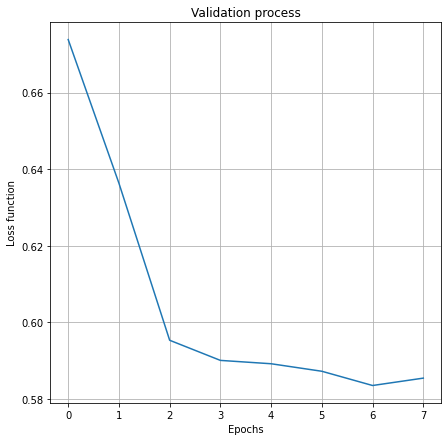

In [87]:
show_losses_graph(valid_losses, training=False)

In [95]:
%%time
y_preds = make_preds(obscene_model, test_data.words)
y_trues = test_data.labels

CPU times: user 2.54 s, sys: 34.2 ms, total: 2.58 s
Wall time: 2.58 s


In [96]:
evaluate_on_texts(y_trues, y_preds)

F1 score: 0.8930584635206957
Accuracy: 0.8930584635206957
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5735
           1       0.23      0.18      0.20       474

    accuracy                           0.89      6209
   macro avg       0.58      0.56      0.57      6209
weighted avg       0.88      0.89      0.89      6209



## Выводы

Модель, обученная на несбалансированных данных, показала лучшие результаты, чем модель, обученная на сбалансированных данных